In [30]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

data = pd.read_csv('MALRatings.csv')
data

,Title,Genres,Rank,Popularity,Score,Episodes,Episode length,Release Date
0,Kaguya-sama wa Kokurasetai: Ultra Romantic,"Comedy,Suspense",13,404,8.99,12,23 min. per ep.,Spring 2022
1,3-gatsu no Lion 2nd Season,"Drama,Slice of Life",14,533,8.96,22,25 min. per ep.,Fall 2017
2,Gintama Movie 2: Kanketsu-hen - Yorozuya yo Ei...,"Action,Comedy,Sci-Fi",19,939,8.93,1,1 hr. 50 min.,NaN
3,Gintama.,"Action,Comedy,Sci-Fi",12,735,8.99,12,24 min. per ep.,Winter 2017
4,Koe no Katachi,NaN,15,19,8.96,1,2 hr. 10 min.,NaN
...,...,...,...,...,...,...,...,...
20338,Steins;Gate,"Drama,Sci-Fi,Suspense",4,13,9.08,24,24 min. per ep.,Spring 2011
20339,High Score,"Comedy,Slice of Life",10527,6095,5.58,8,3 min. per ep.,Fall 2011
20340,Noraneko,NaN,8706,5064,6.04,1,35 sec.,NaN
20341,"Suki de Suki de, Suki de The Animation",NaN,/A,5329,6.81,2,27 min. per ep.,NaN


In [22]:
# Define a function to extract numbers from a string
def extract_number(text):
    if isinstance(text, str):
        match = re.search(r'\d+', text)
        return float(match.group()) if match else np.nan
    return text

In [23]:
#Clean the data
data['Episode length'] = data['Episode length'].apply(extract_number)

data.replace('Unknown', np.nan, inplace=True)

numeric_features = ['Popularity', 'Score', 'Episodes', 'Episode length']
data[numeric_features] = data[numeric_features].astype(float)

data.fillna(data.mean(), inplace=True)

In [25]:
# Select and scale features
features = ['Popularity', 'Score', 'Episodes', 'Episode length']
data_features = data[features]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_features)

In [26]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)


In [27]:
k_values = range(2, 11)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data_pca)
    silhouette_scores.append(silhouette_score(data_pca, cluster_labels))

optimal_k = k_values[np.argmax(silhouette_scores)]


In [28]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(data_pca)


In [29]:
# Add and analyze the cluster labels to the original data
data['Cluster'] = clusters

for i in range(optimal_k):
    cluster_data = data[data['Cluster'] == i]
    print(f"Cluster {i+1}:")

    # Descriptive statistics for each feature
    print(cluster_data[features].describe())

    # Top 5 most common genres in the cluster
    print(cluster_data['Genres'].str.split(', ').explode().value_counts().head(5))

    # Top 5 titles in the cluster by popularity
    print(cluster_data.nsmallest(5, 'Popularity')[['Title', 'Popularity']])

    print("\n")


Cluster 1:
         Popularity         Score      Episodes  Episode length
count  11760.000000  11760.000000  11760.000000    11760.000000
mean   13994.672109      6.080017     11.542755       11.199387
std     4024.060484      0.589120     30.307095       10.531474
min      606.000000      1.840000      1.000000        1.000000
25%    11049.750000      5.750000      1.000000        3.000000
50%    14283.000000      6.451633      1.000000        6.000000
75%    17392.250000      6.451633     12.000000       18.000000
max    20349.000000      7.460000    624.000000       58.000000
Comedy,Slice of Life    351
Adventure,Fantasy       234
Action,Sci-Fi           229
Comedy,Fantasy          189
Adventure,Comedy        152
Name: Genres, dtype: int64
                               Title  Popularity
2237                 Diabolik Lovers       606.0
2408                            Pupa      1100.0
3979                    Boku no Pico      1152.0
11651  Peter Grill to Kenja no Jikan      1203.0
1

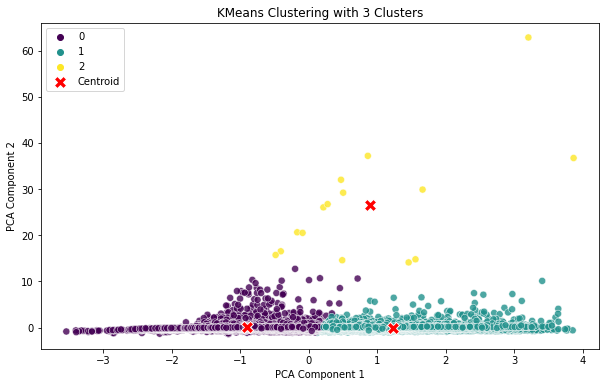

In [31]:
# Create a scatter plot of the PCA-transformed data, colored by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=clusters, palette='viridis', s=50, alpha=0.8)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'KMeans Clustering with {optimal_k} Clusters')
plt.legend(title='Cluster', bbox_to_anchor=(1, 1))

centroids = kmeans.cluster_centers_
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1], color='red', marker='X', s=150, label='Centroid')

plt.show()